In [27]:
import vtk
from vtk.util.numpy_support import vtk_to_numpy
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt

In [23]:
def read_data(dname, vlist, plist, poslist, sizelist):
    folder = os.path.join(os.getcwd(), "convergence_data", dname)
    print(sorted(os.listdir(folder)))
    for filename in sorted(os.listdir(folder)):
        reader = vtk.vtkXMLPolyDataReader()
        reader.SetFileName(os.path.join(folder, filename))
        reader.Update()
        pdata = reader.GetOutput()
        num_particle = pdata.GetNumberOfPoints()
        vlist.append(vtk_to_numpy(pdata.GetPointData().GetArray("Velocity"))[:, :-1])
        plist.append(vtk_to_numpy(pdata.GetPointData().GetArray("Pressure")))

        pos = np.zeros((num_particle, 2))
        for i in range(num_particle):
            pos[i, 0] = pdata.GetPoint(i)[0]
            pos[i, 1] = pdata.GetPoint(i)[1]
        poslist.append(pos)
        sizelist.append(num_particle)
    return vlist, plist, poslist, sizelist

In [24]:
def compare_mesh(i):
    dx = dxlist[i]
    bsize = 2 * 1.3 * dx
    locs = poslist[i]
    ps = plist[i]
    vs = vlist[i]

    inum = int((20 + bsize) / bsize) + 1
    jnum = int((10 + bsize) / bsize) + 1
    grids = np.zeros((inum, jnum, 2))
    pdiff_grids = np.zeros((inum-1, jnum-1, 1))
    vdiff_grids = np.zeros((inum-1, jnum-1, 1))
    for ig in range(inum):
        for jg in range(jnum):
            grids[ig, jg, 0] = -bsize + ig * bsize
            grids[ig, jg, 1] = -bsize + jg * bsize
    for ii in range(inum-1):
        for jj in range(jnum-1):
            xmin, ymin = grids[ii, jj, 0], grids[ii, jj, 1]
            xmax, ymax = grids[ii+1, jj+1, 0], grids[ii+1, jj+1, 1]
            inbox = np.where((locs[:, 0] >= xmin) & (locs[:, 0] <= xmax) & (locs[:, 1] >= ymin) & (locs[:, 1] <= ymax)) 
            ref_inbox = np.where((ref_locs[:, 0] >= xmin) & (ref_locs[:, 0] <= xmax) & (ref_locs[:, 1] >= ymin) & (ref_locs[:, 1] <= ymax)) 

            pdiff_grids[ii, jj, 0] = np.abs(np.mean(ps[inbox]) - np.mean(np.mean(ref_ps[inbox])))
            vdiff_grids[ii, jj, 0] = np.abs(np.mean(np.dot(vs[inbox][:, 0], vs[inbox][:, 1])) \
                                - np.mean(np.dot(ref_vs[ref_inbox][:, 0], ref_vs[ref_inbox][:, 1])))
    pdiff = np.sqrt(np.nanmean(pdiff_grids))
    vdiff = np.sqrt(np.nanmean(vdiff_grids))
    return pdiff, vdiff

In [25]:
dxlist = [0.02, 0.04, 0.05, 0.08, 0.1, 0.16, 0.2, 0.4, 0.5, 0.8]

def get_diff(dname):
    sizelist = []
    vlist = []
    plist = []
    poslist = []
    vlist, plist, poslist, sizelist = read_data(dname, vlist, plist, poslist, sizelist)
    ref_dx = dxlist[0]
    ref_locs = poslist[0]
    ref_ps = plist[0]
    ref_vs = vlist[0]
    pdiff_list = np.zeros((len(dxlist) - 1))
    vdiff_list = np.zeros((len(dxlist) - 1))
    for i in range(1, len(dxlist)):
        dx = dxlist[i]
        bsize = 2 * 1.3 * dx
        locs = poslist[i]
        ps = plist[i]
        vs = vlist[i]

        inum = int((20 + bsize) / bsize) + 1
        jnum = int((10 + bsize) / bsize) + 1
        grids = np.zeros((inum, jnum, 2))
        pdiff_grids = np.zeros((inum-1, jnum-1, 1))
        vdiff_grids = np.zeros((inum-1, jnum-1, 1))
        for ig in range(inum):
            for jg in range(jnum):
                grids[ig, jg, 0] = -bsize + ig * bsize
                grids[ig, jg, 1] = -bsize + jg * bsize
        for ii in range(inum-1):
            for jj in range(jnum-1):
                xmin, ymin = grids[ii, jj, 0], grids[ii, jj, 1]
                xmax, ymax = grids[ii+1, jj+1, 0], grids[ii+1, jj+1, 1]
                inbox = np.where((locs[:, 0] >= xmin) & (locs[:, 0] <= xmax) & (locs[:, 1] >= ymin) & (locs[:, 1] <= ymax)) 
                ref_inbox = np.where((ref_locs[:, 0] >= xmin) & (ref_locs[:, 0] <= xmax) & (ref_locs[:, 1] >= ymin) & (ref_locs[:, 1] <= ymax)) 

                pdiff_grids[ii, jj, 0] = np.abs(np.mean(ps[inbox]) - np.mean(np.mean(ref_ps[inbox])))
                vdiff_grids[ii, jj, 0] = np.abs(np.mean(np.dot(vs[inbox][:, 0], vs[inbox][:, 1])) \
                                    - np.mean(np.dot(ref_vs[ref_inbox][:, 0], ref_vs[ref_inbox][:, 1])))
                
        pdiff_list[i-1] = np.sqrt(np.nanmean(pdiff_grids))
        vdiff_list[i-1] = np.sqrt(np.nanmean(vdiff_grids))
    return pdiff_list, vdiff_list

In [26]:
ie_pdiff, ie_vdiff = get_diff('ie')
print("ie pdiff: ", ie_pdiff)
print("ie vdiff: ", ie_vdiff)

['ie_0.02.vtp', 'ie_0.04.vtp', 'ie_0.05.vtp', 'ie_0.08.vtp', 'ie_0.1.vtp', 'ie_0.16.vtp', 'ie_0.2.vtp', 'ie_0.4.vtp', 'ie_0.5.vtp', 'ie_0.8.vtp']
ie pdiff:  [107.49123187 113.51755085 119.70105374 124.87077056 130.49965441
 128.88620808 139.72684369 145.98254    132.62580034]
ie vdiff:  [ 1.75234607  2.32719311  3.87416308  4.93181602  7.81997438  9.74302909
 18.18846415 24.05635928 35.61992671]


<Figure size 1500x750 with 0 Axes>

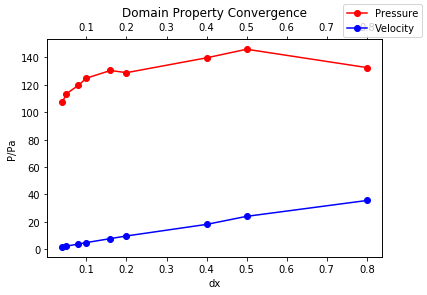

In [39]:
plt.figure(figsize=[10, 5], dpi=150)

fig, ax1 = plt.subplots()

ax1.set_title("Domain Property Convergence")
ax1.set_xlabel('dx')
ax1.set_ylabel('P/Pa')
ax1.plot(dxlist[1:], ie_pdiff, 'r-o', label='Pressure')

ax2 = ax1.twiny()  # instantiate a second axes that shares the same x-axis

ax2.set_ylabel('v/$m s^{-1}$')  # we already handled the x-label with ax1
ax2.plot(dxlist[1:], ie_vdiff, 'b-o', label='Velocity')
fig.legend()

